# Brain & Breast Tumor Detection with Trigonometric Convolutions

## Objective:
- Prepare MRI and mammogram images
- Design TrigConv2D layer to capture structural and textural features
- Apply classification + segmentation


In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2, os
import kagglehub


In [2]:
# Simulate TrigConv2D layer
from tensorflow.keras.layers import Layer
class TrigConv2D(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(TrigConv2D, self).__init__(**kwargs)
        self.conv = Conv2D(filters, kernel_size, padding='same')

    def call(self, inputs):
        x = tf.math.sin(inputs) + tf.math.cos(inputs)
        return self.conv(x)


In [3]:
# Sample model using TrigConv2D
def build_trig_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = TrigConv2D(32, (3, 3))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = TrigConv2D(64, (3, 3))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_trig_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trig_conv2d (TrigConv2D)        │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trig_conv2d_1 (TrigConv2D)      │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,314 (16.07 MB)

 Trainable params: 4,213,314 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def load_images_from_drive_recursive(base_path, target_size=(128, 128)):
    X, y, class_names = [], [], []
    class_map = {}

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                class_name = os.path.basename(os.path.dirname(root))
                if class_name not in class_map:
                    class_map[class_name] = len(class_map)
                label = class_map[class_name]

                img_path = os.path.join(root, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    img = cv2.resize(img, target_size)
                    img = img / 255.0
                    X.append(img)
                    y.append(label)
                except:
                    continue

    X = np.array(X).reshape(-1, target_size[0], target_size[1], 1)
    y = to_categorical(y, num_classes=len(class_map))
    return X, y, list(class_map.keys())


In [5]:
base_path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")  # or "DRIVE/breast"
X, y, class_names = load_images_from_drive_recursive(base_path)
print("Loaded:", len(X), "images.")
print("Classes:", class_names)


Loaded: 10237 images.
Classes: ['jpeg']


In [6]:
from tensorflow.keras.utils import to_categorical

# Ensure labels are converted to categorical
y = to_categorical(y, num_classes=2)


Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


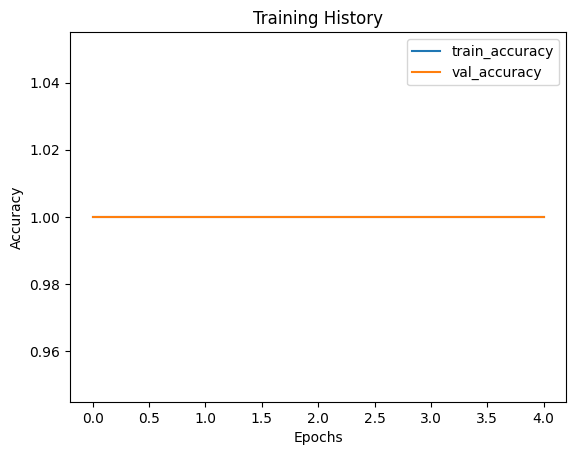

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()